## Imports

In [59]:
import torch
from PIL import Image, ImageOps
import pickle
from torchvision import models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import Dataset, DataLoader
import time
import copy
import matplotlib.pyplot as plt
from functions import notch_selector

## Load filepaths

In [60]:
#image paths were chosen in 08

name_right = 'nochers_5x350_right' #enter name_right of the pickle file
with open(name_right, 'rb') as f:
    image_paths_right = pickle.load(f)

name_left = 'nochers_5x350_left' #enter name_left of the pickle file
with open(name_left, 'rb') as f:
    image_paths_left = pickle.load(f)

## Path list shapes

In [61]:
np.array(image_paths_right).shape, np.array(image_paths_left).shape

((5, 350), (5, 350))

## Invertion

In [62]:
#made in 07 (lazy load)
#invertor = torch.load('invertor_model_95.pt')

## Invertor model

In [63]:
preprocess= transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor()
])

input_size = 3*224*224
num_classes = 2
hidden_size = 100

class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.l2 = nn.Linear(hidden_size, num_classes)
            
    def forward(self, x):
        out = self.l1(x)
        out = self.relu(out)
        out = self.l2(out)
        return out
        
model_inv = NeuralNetwork(input_size, hidden_size, num_classes)
model_inv.load_state_dict(torch.load('invertor_model_95.pt'))
model_inv.eval()#does not follow gradients any more (for testing)

dicto = {0:'NOT INVERTED', 1:'INVERTED'}

## Invertor testing

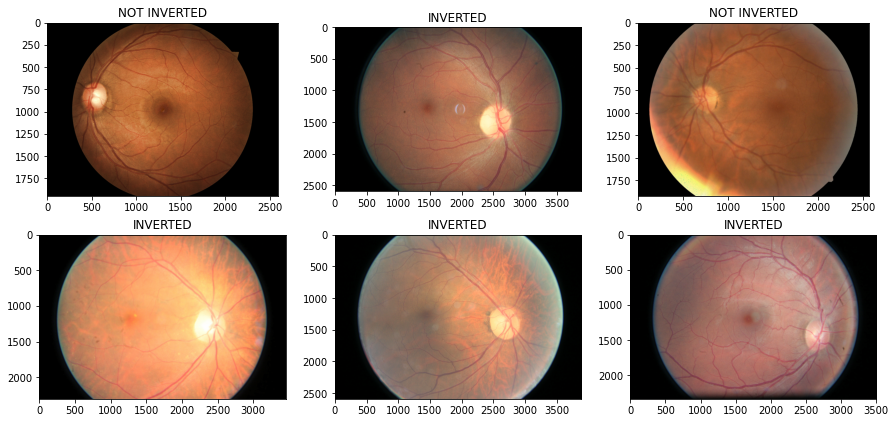

In [64]:
fig, ax = plt.subplots(2,3, figsize=(15,7))

l = [1,4,6,11,12,17]

for i,j in enumerate(l):
    img_path=image_paths_left[0][j]
    input_image = Image.open(img_path)
    input = preprocess(input_image)
    input_tensor = input.reshape(-1, 3*224*224)

    inverted = torch.argmax(model_inv(input_tensor)).item()

    row,col = divmod(i,3)
    dicto = {0:'NOT INVERTED', 1:'INVERTED'}
    ax[row][col].set_title(dicto[inverted])
    ax[row][col].imshow(input_image);

## Image preprocessing functions

In [65]:
preprocess_n= transforms.Compose([
    transforms.Resize(290),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

preprocess_i= transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

toTensor = transforms.Compose([
    transforms.ToTensor()
])

## Left eye images preparation

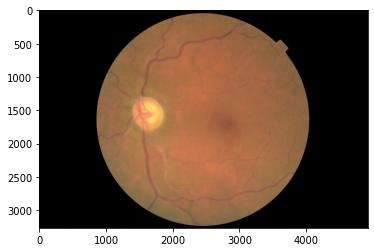

In [66]:
toTensor = transforms.Compose([
    transforms.ToTensor()
])

path = image_paths_left[1][0]
input_image = Image.open(path)
t=toTensor(input_image)
t.shape
plt.imshow(t.permute(1, 2, 0))
input_tensor = t.flip([2])
#plt.imshow(input_tensor.permute(1, 2, 0))

In [67]:
def Transformator_left(paths):
    categories = 5
    samples_per_category = len(paths[0])
    data = torch.zeros((samples_per_category*categories, 3, 224, 224))
    labels = []

    for i in range(samples_per_category):
        for j in range(categories):
            path = paths[j][i]
            input_image = Image.open(path)
            if not notch_selector(path):
                input_tensor = preprocess(input_image).reshape(-1, 3*224*224)
                inverted = torch.argmax(model_inv(input_tensor)).item()
                input_tensor = preprocess_i(input_image)
                if inverted:
                    input_tensor = input_tensor.flip([1,2])
            else:
                input_tensor = preprocess_n(input_image)
            inx = i*categories+j
            if inx % 250 == 0 and j == 0:
                print(f'{inx}/{categories*samples_per_category}')
            data[inx] = input_tensor
            labels.append(j)
    return data, labels                   
                
lefts, labels_l = Transformator_left(image_paths_left)

0/1750
250/1750
500/1750
750/1750
1000/1750
1250/1750
1500/1750


## Right eye images preparation

In [68]:
def Transformator_right(paths):
    categories = 5
    samples_per_category = len(paths[0])
    data = torch.zeros((samples_per_category*categories, 3, 224, 224))
    labels = []

    for i in range(samples_per_category):
        for j in range(categories):
            path = paths[j][i]
            input_image = Image.open(path)
            if not notch_selector(path):
                input_tensor = preprocess(input_image).flip([2]).reshape(-1, 3*224*224)
                inverted = torch.argmax(model_inv(input_tensor)).item()
                input_tensor = preprocess_i(input_image)
                if inverted:
                    input_tensor = input_tensor.flip([1])#only upside-down!!!!
                else:
                    input_tensor = input_tensor.flip([2])#mirrored to be left!!!!!!                    
            else:
                input_tensor = preprocess_n(input_image)
                input_tensor = input_tensor.flip([2])#mirrored to be left!!!!!!
            inx = i*categories+j
            if inx % 250 == 0 and j == 0:
                print(f'{inx}/{categories*samples_per_category}')
            data[inx] = input_tensor
            labels.append(j)
    return data, labels                   
                
rights, labels_r = Transformator_right(image_paths_right)

0/1750
250/1750
500/1750
750/1750
1000/1750
1250/1750
1500/1750


In [69]:
lefts.shape, rights.shape

(torch.Size([1750, 3, 224, 224]), torch.Size([1750, 3, 224, 224]))

## Save preprocessed tensors and labels

In [70]:
data=torch.cat((lefts,rights),0)
labels = np.array(labels_l+labels_r)

torch.save(data, 'complete_tensor_3500.pt')
with open('complete_labels_3500.npy', 'wb') as f:
    np.save(f, labels)

## Loading images

In [71]:
data = torch.load('complete_tensor_3500.pt')

## Visual testing

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


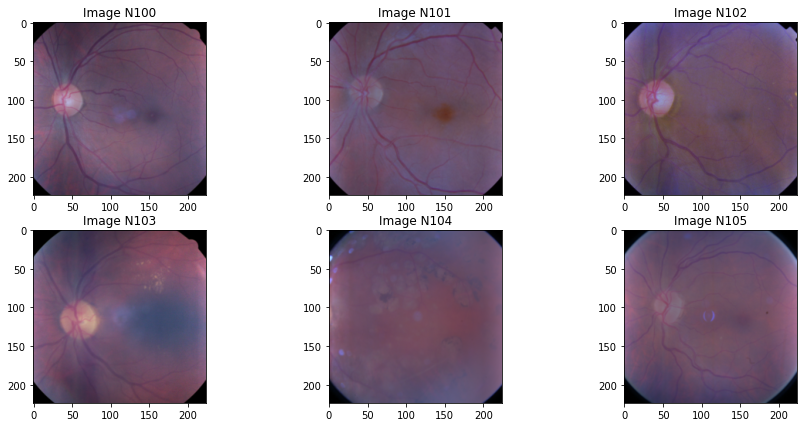

In [72]:
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0., 0., 0. ],
                                                     std = [ 1/0.229, 1/0.224, 1/0.225 ]),
                                transforms.Normalize(mean = [ -0.485, -0.456, -0.406 ],
                                                     std = [ 1., 1., 1. ]),
                               ])
invTrans = transforms.Compose([ transforms.Normalize(mean = [ 0.4, 0.4, 0.4 ],
                                                     std = [ 0.4,0.4,0.4 ])
                               ])


fig, ax = plt.subplots(2,3, figsize=(15,7))

start = 100
l = range(start, start+6)

for i,j in enumerate(l):
    inv_tensor = data[j]
    #inv_tensor = invTrans(inp_tensor)
    row,col = divmod(i,3)
    ax[row][col].set_title(f'Image N{j:02}')
    inv_array = inv_tensor.permute(1, 2, 0)
    ax[row][col].imshow(inv_array);

## Creating Dataset class that binds tensor and label

In [73]:
class Data(Dataset):
    
    def __init__(self, data, labels):
        self.x = data
        self.y = torch.from_numpy(labels)
        self.samples = data.shape[0]
        self.features = data.shape[1]
        
    def __getitem__(self, index):
        # define indexing
        return self.x[index], self.y[index]
        
    def __len__(self):
        # len(dataset)
        return self.samples

dataset = Data(data, labels)  

### Spliting samples on train-test
### Creating tensor-label dataset
### Creating dataloaders
### Loading Resnet18 model
### Creating adn preformulating Resnet model
### Defining optimizer, criterion and schedular
### Model training
### Model testing 
### Calculate accuracy

In [74]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size = 0.2)

class Data(Dataset):
    
    def __init__(self, data, labels):
        self.x = data
        self.y = torch.from_numpy(labels)
        self.samples = data.shape[0]
        self.features = data.shape[1]
        
    def __getitem__(self, index):
        # define indexing
        return self.x[index], self.y[index]
        
    def __len__(self):
        # len(dataset)
        return self.samples

train = Data(X_train, y_train)
test = Data(X_test, y_test)
print(f'train: {len(train)}, test: {len(test)}')

datasets = {'train': train, 'test': test}
dataloaders = {x: DataLoader(datasets[x], batch_size=5, num_workers=0) for x in ['train', 'test']}
dataset_sizes = {x: len(datasets[x]) for x in ['train', 'test']}
class_names = np.unique(labels)

model = models.resnet18(pretrained = True)

#model preformulation - we have 5 classes
model.fc = nn.Linear(512,5)

#CPU to GPU if available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

#loss
criterion = nn.CrossEntropyLoss()

#optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)

#decay lr by 0.1 for every 7 epochs
schedular = lr_scheduler.StepLR(optimizer, step_size = 7, gamma = 0.1)


def train_model(model, criterion, optimizer, scheduler, num_epochs = 10):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'test']:
            print(f'phase: {phase}')
            if phase == 'train':
                model.train()
            else:
                model.eval()
            
            running_loss = 0.0
            running_corrects = 0

            batch_number=0
            for inputs, labels in dataloaders[phase]:
                #if batch_number%5==0:
                    #print(f'batch munber: {batch_number}')
                batch_number+=1
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels.long())

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    model.load_state_dict(best_model_wts)
    return model

train_model(model, criterion, optimizer, schedular, num_epochs = 10)


train: 2800, test: 700
Epoch 1/10
----------
phase: train
train Loss: 1.6172 Acc: 0.3318
phase: test
test Loss: 1.6686 Acc: 0.3471

Epoch 2/10
----------
phase: train
train Loss: 1.3231 Acc: 0.4543
phase: test
test Loss: 1.6057 Acc: 0.3943

Epoch 3/10
----------
phase: train
train Loss: 0.9764 Acc: 0.6171
phase: test
test Loss: 1.8542 Acc: 0.3686

Epoch 4/10
----------
phase: train
train Loss: 0.8363 Acc: 0.6911
phase: test
test Loss: 2.4960 Acc: 0.3714

Epoch 5/10
----------
phase: train
train Loss: 0.7352 Acc: 0.7321
phase: test
test Loss: 2.7275 Acc: 0.3200

Epoch 6/10
----------
phase: train
train Loss: 0.6152 Acc: 0.7650
phase: test
test Loss: 2.5467 Acc: 0.3143

Epoch 7/10
----------
phase: train
train Loss: 0.5288 Acc: 0.8118
phase: test
test Loss: 2.4298 Acc: 0.4471

Epoch 8/10
----------
phase: train
train Loss: 0.3522 Acc: 0.8743
phase: test
test Loss: 2.0608 Acc: 0.4486

Epoch 9/10
----------
phase: train
train Loss: 0.0928 Acc: 0.9793
phase: test
test Loss: 2.0763 Acc: 0.45

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [58]:
l = np.array([[50,60,70],[10,20,30]])
mid = np.array([80,90,100])

l*(mid/np.mean(l, axis = 0))

l = torch.tensor([[50.,60.,70.],[10.,20.,30.]])
mid = torch.tensor([80.,90.,100.])
l, mid
l*(mid/torch.mean(l, 0))

img = torch.tensor([[[0.3,0.33],
                     [0.27, 0.3]],
                     [[0.2, 0.17],
                     [0.23, 0.2]],
                     [[0.4, 0.43],
                     [0.37, 0.4]]])

m = torch.mean(torch.mean(img, 1),1)

normalized_img=(img.permute(1,2,0)*torch.tensor([0.4,0.3,0.4])/torch.mean(torch.mean(img, 1),1)).permute(2,0,1)
normalized_img



tensor([[[0.4000, 0.4400],
         [0.3600, 0.4000]],

        [[0.3000, 0.2550],
         [0.3450, 0.3000]],

        [[0.4000, 0.4300],
         [0.3700, 0.4000]]])